## 05 - Görüntü Onarımı
### Bölüm 2 - Bulanıklaştırma

Bu not defterinde, genellikle görüntüdeki **bulanıklık** etkisini azaltmak için uygulanan görüntü ters evrişimi problemini ele alıyoruz.

Görüntü restorasyonu, özellikle *bulanıklık* ve *gürültü* gibi görüntüyü bozan süreç hakkındaki ön bilgileri kullanarak görüntülerin görsel kalitesini iyileştirmekle ilgilidir. Görüntü kalitesinin iyileştirilmesine izin vermek için bir yöntemin keyfi olarak seçildiği görüntü iyileştirme tekniklerinin aksine, restorasyon genellikle görüntü oluşturma sürecini dikkate alır:

$$g(\mathbf{x}) = \mathcal{N} \left\lbrace f(\mathbf{x}) * h(\mathbf{x}) \right\rbrace,$$
burada $g$ gözlemlenen veya elde edilen görüntüdür, $f$ ideal veya orijinal görüntüdür, $h$ belirli bir pikselden gelen verilerin *yayılması* olarak tanımlanan görüntüde oluşan bozulmayı açıklayan filtredir $ f(\mathbf{x})$'ı $g(\mathbf{x})$ merkezli bir mahalleye bağlar ve $\mathcal{N}$, $g(\ görüntüsündeki *gürültüyü* açıklayan stokastik bir süreçtir. mathbf{x})$.

**Görüntü restorasyonu**, orijinal görüntü $f$'nin $\hat{f}$ tahminini elde etme işlemidir.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from scipy.fftpack import fftn, ifftn, fftshift

### Bozulma işlevi ve Nokta Yayılma İşlevi

$h(\mathbf{x})$ işlevi, piksellerin merkezden komşu piksellere nasıl yayıldığını tanımlar. Bu tür işlevler, görüntü restorasyon algoritmalarını kullanırken tersine çevirmek istediğimiz bozulmayı yönlendirir. Bu tür fonksiyona genellikle görüntüleme sisteminin dürtü tepkisi veya nokta yayılma fonksiyonu denir.

Nokta yayılma fonksiyonunu simüle etmenin bir yolu olarak Gauss filtresi (genellikle çekirdek olarak da adlandırılır) oluşturmak için bir fonksiyon oluşturalım. Bu fonksiyon, bir edinim sistemi tarafından ortaya çıkan bulanıklığı simüle etmek için kullanılabilir.

Görüntü oluşumunun dikkate aldığı şeyin, bir noktanın enerjisini çevredeki piksellere *yayan* bir fonksiyon olduğunu unutmayın; dolayısıyla Gaussian gibi bir filtrenin yaptığı da aslında budur. Fonksiyona bir göz atalım:
$$\frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}(x/\sigma)^2}$$


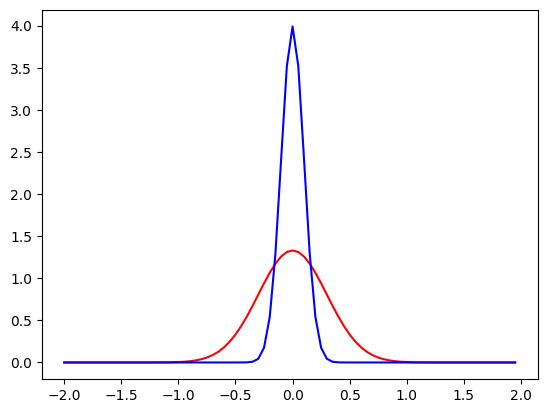

In [7]:
x = np.arange(-2,2,0.05)

# parametre sigma değerlerin dağılımı ile ilgilidir
sigma1 = 0.3
gauss1d_1 = (1/(sigma1*np.sqrt(2*np.pi))) * np.exp(-(np.square(x/sigma1)/2))

sigma2 = 0.1
gauss1d_2 = (1/(sigma2*np.sqrt(2*np.pi))) * np.exp(-(np.square(x/sigma2)/2))

plt.plot(x, gauss1d_1, 'r') # daha büyük sigma, 0,3
plt.plot(x, gauss1d_2, 'b') # daha küçük sigma, 0,1

Mavi grafiğin $\sigma = 0,15$ değerleri 0 civarında daha yoğun bir bölgede nasıl dağıttığına, kırmızı çizginin ise değerleri yayan bir dağılımı tanımladığına dikkat edin. $\sigma$ değerini artırarak düzgün dağılıma yaklaşırız.

Görüntülerde bu tür bir işlevi kullanmak için, bunun 2 boyutlu bir versiyonuna ihtiyacımız var ve evrişim yoluyla uygulanacak filtrelerde kodlanacak şekilde ayrıklaştırılmış.

In [8]:
def gaussian_filter(k=5, sigma=1.0):
    ''' Gauss filtresi
    :param k: çekirdeğin/filtrenin yan boyutunu tanımlar, varsayılan 5
    :param sigma: Gauss dağılımının standart sapması (dağılım)
    : evrişim işlemlerinde kullanılacak [k x k] filtreli dönüş matrisi
    '''
    arx = np.arange((-k // 2) + 1.0, (k // 2) + 1.0)
    x, y = np.meshgrid(arx, arx)
    filt = np.exp(-(1/2) * (np.square(x) + np.square(y)) / np.square(sigma))
    return filt / np.sum(filt)

In [9]:
g1 = gaussian_filter(k=5, sigma=0.9)
print(g1)

[[0.00141805 0.00903528 0.01675038 0.00903528 0.00141805]
 [0.00903528 0.05756927 0.10672687 0.05756927 0.00903528]
 [0.01675038 0.10672687 0.19785944 0.10672687 0.01675038]
 [0.00903528 0.05756927 0.10672687 0.05756927 0.00903528]
 [0.00141805 0.00903528 0.01675038 0.00903528 0.00141805]]


Bu, radyal bir dağılımı tanımlayan simetrik bir fonksiyondur. Merkezi değerin en büyük olduğuna ve geri kalan değerlerin üstel olarak azaldığına dikkat edin. Bu fonksiyon, toplamı bir olacak şekilde normalleştirilir, böylece evrişim uygulandığında görüntünün **enerjisi** değişmez.

Daha büyük bir filtre oluşturalım ve **radyal yayılma** modelini gösterecek şekilde ısı haritasını çizelim

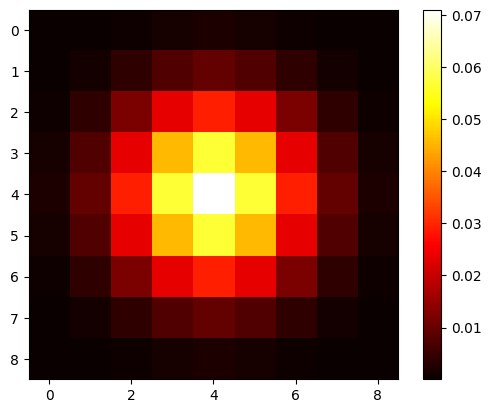

In [10]:
g2 = gaussian_filter(k=9, sigma=1.5)
plt.imshow(g2, cmap='hot', interpolation='nearest')
plt.colorbar()

### Bulanıklaştırma simülasyonu
Bulanıklığı simüle etmek için, Fourier Dönüşümünü kullanarak bir görüntüyü bu tür işlevlerden biriyle evriştireceğiz ve bir $g$ görüntüsü yaratacağız. Fourier alanında:
$$G(\mathbf{u}) = F(\mathbf{u})H(\mathbf{u})$$

Ancak $H$ ve $F$'nin aynı boyuta sahip olması gerektiğini unutmayın. Bu nedenle $h$ fonksiyonunu sıfırlamamız gerekiyor.

<ipython-input-11-55913377ce4e>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  f = imageio.imread("/content/pattern2.png")


Text(0.5, 1.0, 'degraded/blurred image')

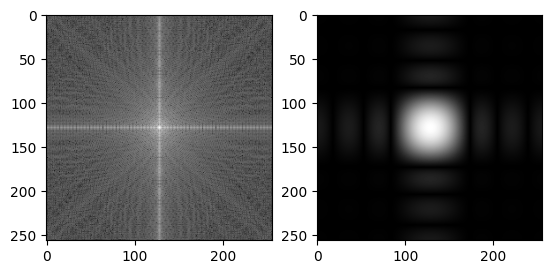

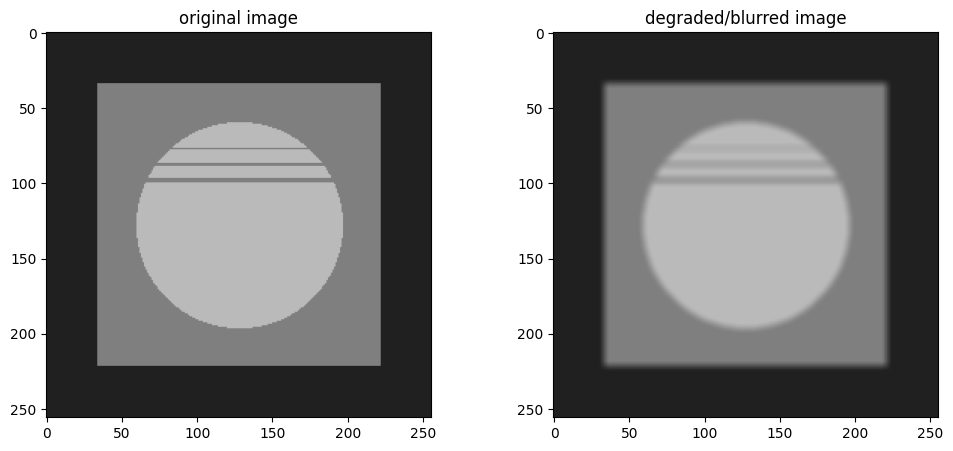

In [11]:
f = imageio.imread("/content/pattern2.png")
h = gaussian_filter(k=7, sigma=2.5)

# bir taraftaki dolgu sayısını hesaplamak
a = int(f.shape[0]//2 - h.shape[0]//2)
h_pad = np.pad(h, (a,a-1), 'constant', constant_values=(0))

# Fourier dönüşümlerini hesaplamak
F = fftn(f)
H = fftn(h_pad)

plt.subplot(121)
plt.imshow(fftshift(np.log(np.abs(F)+1)), cmap="gray")
plt.subplot(122)
plt.imshow(fftshift(np.log(np.abs(H)+1)), cmap="gray")

# evrişim
G = np.multiply(F,H)

# Ters Dönüşüm
# - görüntüyü uzay alanında yeniden yapılandırmadan önce FFT kaydırması yapmamız gerekiyor
g = fftshift(ifftn(G).real)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(f, cmap="gray", vmin=0, vmax=255); plt.title("original image")
plt.subplot(122)
plt.imshow(g, cmap="gray", vmin=0, vmax=255); plt.title("degraded/blurred image")

### Ters filtre

Ters filtre, $\hat{f}$ orijinal görüntüsüne ilişkin bir tahmin elde ederek evrişim sürecini tersine çevirme girişimidir.

$$\hat{F}(\mathbf{u}) = \frac{G(\mathbf{u})}{H(\mathbf{u})}$$

$H$ veya bozunma işlevi hakkında bilgi sahibi olduğumuzu varsaydığımızı unutmayın. Bu nedenle $h$ ve $g$'ı biliyoruz ve $f$'ı yeniden yapılandırmak istiyoruz.

Text(0.5, 1.0, 'restored image')

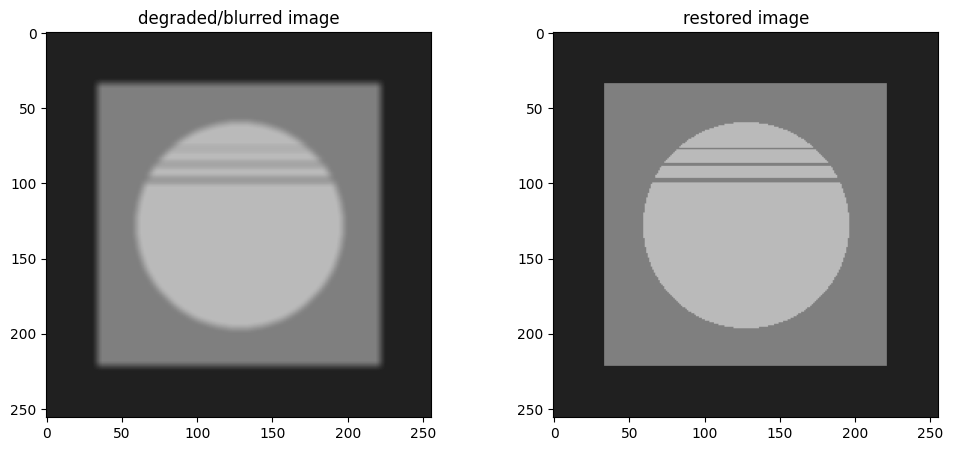

In [12]:
#F_hat = G/H
F_hat = np.divide(G,H)

f_hat = ifftn(F_hat).real

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(g, cmap="gray", vmin=0, vmax=255); plt.title("degraded/blurred image")
plt.subplot(122)
plt.imshow(f_hat, cmap="gray", vmin=0, vmax=255); plt.title("restored image")


Gördüğümüz gibi ters filtrenin sonuçları gerçekten çok iyi! Ancak gürültüsüz bir senaryo ve iyi davranan bir H fonksiyonu varsaydık. Bunun işe yaramayacağı iki durumu görelim:

1. Yanlış oluşturulmuş problem: $h$'ın tersi olmadığında veya Fourier dönüşümü $H$ sıfır katsayılara sahip olduğunda, ters filtreyi doğrudan gerçekleştiremeyiz

2. Gürültü: Görüntü gürültü nedeniyle bozulduğunda bu terim denklemde dikkate alınmalıdır ve içeriği çoğunlukla Fourier spektrumunun yüksek frekans bölgelerinde olduğundan gürültünün artmasına neden olur.


Text(0.5, 1.0, 'noisy and blurred image')

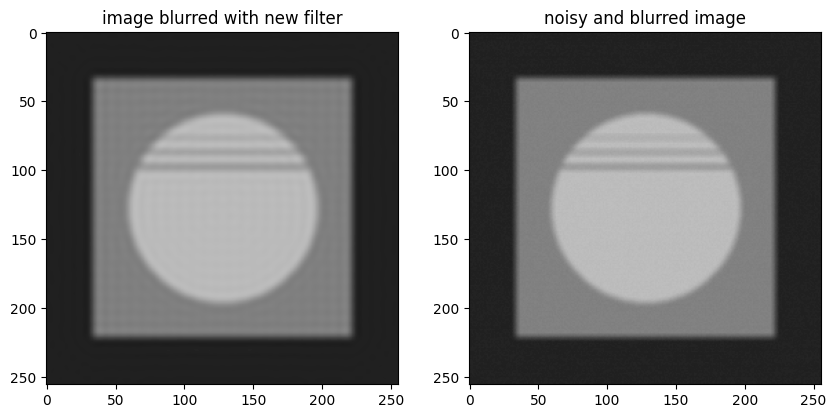

In [13]:
# 1. yeni bir h oluşturmak ve sıfır ve sıfıra yakın değerleri içerecek şekilde değiştirmek
Hz = np.array(H,copy=True)
Hz[np.abs(H)<0.4] = 0.0001
Hz[np.abs(H)<0.2] = 0.0
h_z = ifftn(Hz).real[122:135,122:135]
h_z = h_z/np.sum(h_z)

# şimdi bozulmuş görüntüyü hesaplıyoruz
Gz = np.multiply(F , Hz) # case 1

# 2. görüntüye gürültü eklemek
g_noise = (g.astype(np.int32) + np.random.randint(5, size=f.shape)).astype(np.uint8)
Gn = fftn(g_noise) # taking it FFT

# Ters Dönüşüm
# - evrilmiş görüntü için görüntüyü uzay alanında yeniden yapılandırmadan önce FFT kaydırması yapmamız gerekiyor
gz = fftshift(ifftn(Gz).real)
gn = ifftn(Gn).real

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(gz, cmap="gray", vmin=0, vmax=255); plt.title("image blurred with new filter")
plt.subplot(122)
plt.imshow(gn, cmap="gray", vmin=0, vmax=255); plt.title("noisy and blurred image")

Her iki görüntü de bir öncekine benzer, ancak bir ters filtre kullanmayı deneyelim.

<ipython-input-14-a17348c13953>:11: RuntimeWarning: divide by zero encountered in divide
  Fz_hat = np.divide(Gz,Hz)
<ipython-input-14-a17348c13953>:11: RuntimeWarning: invalid value encountered in divide
  Fz_hat = np.divide(Gz,Hz)


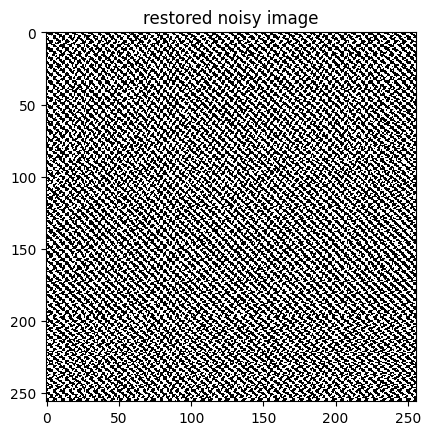

In [14]:
# FFT'leri hesapla
Gz = fftn(gz)
Gn = fftn(gn)

# gürültülü görüntüyle ters filtreleme
Fn_hat = np.divide(Gn,H)
fn_hat = fftshift(ifftn(Fn_hat).real)
plt.imshow(fn_hat, cmap="gray", vmin=0, vmax=255); plt.title("restored noisy image")

# sıfır değerli H ile ters filtreleme
Fz_hat = np.divide(Gz,Hz)


Sıfıra bölme nedeniyle görüntüleri ters filtreleyemeyiz.

Ayrıca, gürültü eklenmiş görüntü, yalnızca gürültüyle sonuçlanacağı için hiçbir şekilde yeniden oluşturulamamıştır.

Sıfırı (veya sıfıra yakın değerleri) sabit bir değerle değiştiren **sözde ters** filtrelemeyi uygulayalım.

Text(0.5, 1.0, 'restored image')

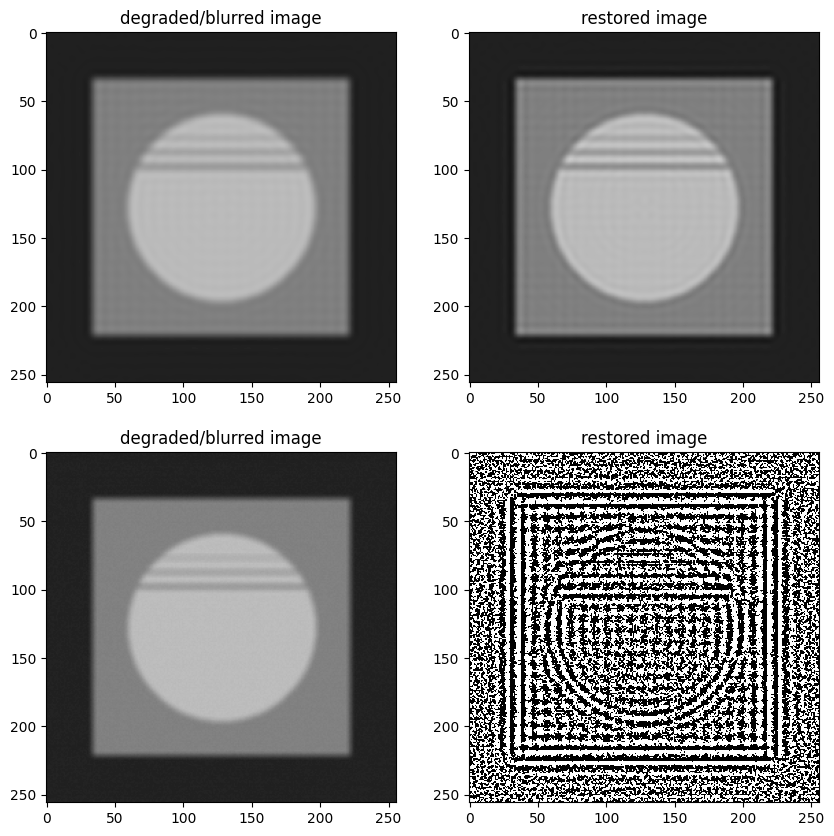

In [15]:
# sıfıra yakın değerleri sabit bir değerle dolduracak bir değer seçin
Hz[np.abs(Hz)<=0.0002] = 0.0002

# ters filtreleme
Fz_hat = np.divide(Gz,Hz)
Fn_hat = np.divide(Gn,Hz)

# ters FFT
fz_hat = fftshift(ifftn(Fz_hat).real)
fn_hat = ifftn(Fn_hat).real

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(gz, cmap="gray", vmin=0, vmax=255); plt.title("degraded/blurred image")
plt.subplot(222)
plt.imshow(fz_hat, cmap="gray", vmin=0, vmax=255); plt.title("restored image")
plt.subplot(223)
plt.imshow(gn, cmap="gray", vmin=0, vmax=255); plt.title("degraded/blurred image")
plt.subplot(224)
plt.imshow(fn_hat, cmap="gray", vmin=0, vmax=255); plt.title("restored image")

Bu bize en azından Fourier dönüşümü sıfır değere sahip olan bir psf ile evrilmiş görüntünün bir tahminini hesaplama olanağı tanır, ancak yeniden yapılandırma optimalin altındadır.

Ancak gürültülü görüntü nedeniyle restorasyon hala kabul edilemez.

Bu nedenle gerçek vakalarda daha fazla bilginin dikkate alınması gerekir. Bu senaryoda en küçük karelere dayalı filtreler yaygındır; örneğin Wiener Filtresi ve Kısıtlanmış En Küçük Kareler Filtresi.